# Solar home control: Model Predictive Control with JuMP

Data:

* P_sun: solar power potential
* P_load: consumption (load shedding not used)

Decision variables:

* P_sto: storage power, in receptor convention
* P_grid: grid power
* P_curt: PV curtailement

P_grid and P_curt can be used as recourses, that is changed at the last moment (after the battery schedule had been fixed)

Cost function: minimize sum(P_grid), that is the energy bill (assuming a fixed price for energy)

In [1]:
using JuMP
using Clp
#using PyPlot

In [17]:
using Gadfly

## 1) Load problem data

TODO 2018-04-30: write a generic load_data function, like in Python and Matlab

### Ratings

In [2]:
E_rated = 8 # kWh
P_grid_max = 3 # kW, more than data
P_pvp = 4 # kW

4

### Test data

In [4]:
(7585 - 7250)/48

6.979166666666667

In [14]:
data, header = readcsv("../../data/data_2011-2012.csv", header=true)

date = data[:,1]
data = data[:,2:end]
data = Array{Float64}(data)

# slice the proper rows (30 test days)
r_first = 7250 #2011-11-29 00:00:00,0.52,0.0
r_last = 7585 # 2011-12-05 23:30:00,0.424,0.0

ndays = 30
R1 = 7250 -1;           # Line 7250: 2011-11-29 00:00:00,0.52,0.0
R2 = R1 + ndays*48 - 1; # Line 8689: 2011-12-28 23:30:00,0.35,0.0

data = data[R1:R2, :]
date = date[R1:R2]
date[1], date[end]

("2011-11-29 00:00:00", "2011-12-28 23:30:00")

In [15]:
P_load = data[:,1];
# scaling of PV production
P_sun = data[:,2]/1.04*P_pvp;

n = length(P_load)
t = (0:(n-1))*0.5 # hours
td = t/24 # days
dt = 0.5 # hours

0.5

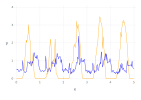

In [31]:
plot(layer(x=td[1:5*48], y=P_load[1:5*48], Geom.line, Theme(default_color=colorant"blue")  ),
     layer(x=td[1:5*48], y=P_sun[1:5*48],  Geom.line, Theme(default_color=colorant"orange") ) )

### Forecast data

In [23]:
cons_dpat, header = readcsv("../../data/daily_pattern_cons_M-1-2011-11-28.csv", header=true)

hod = cons_dpat[:,1];
cons_dmean = cons_dpat[:,2];

prod_dpat, header = readcsv("../../data/daily_pattern_prod_M-1-2011-11-28.csv", header=true)
prod_dmean = prod_dpat[:,2];
prod_dmean .*= P_pvp/1.04;

In [24]:
P_load_fc = repeat(cons_dmean, outer=ndays);
P_sun_fc = repeat(prod_dmean, outer=ndays);

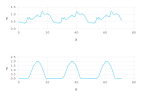

In [25]:
fig1a = plot(x=t[1:48*3], y=P_load_fc[1:48*3], Geom.line)
fig1b = plot(x=t[1:48*3], y=P_sun_fc[1:48*3], Geom.line)
fig1 = vstack(fig1a, fig1b)

## 2) Build optim problem

In [111]:
pos(x) = x>0 ? x : 0

pos (generic function with 1 method)

### Anticipative

battery schedule depends on the future data

In [159]:
function optim_anticip(P_sun, P_load)
    m = Model(solver = ClpSolver())
    
    @variable(m, 0 <= E[1:n+1] <= E_rated)
    @variable(m, 0 <= P_grid[1:n] <= P_grid_max)
    @variable(m, P_curt[1:n] >= 0)
    @variable(m, P_sto[1:n])

    for k = 1:n
        @constraint(m, E[k+1] == E[k] + P_sto[k]*dt)
        @constraint(m, P_sun[k] - P_curt[k] + P_grid[k] == P_sto[k] + P_load[k])
        @constraint(m, P_curt[k] <= P_sun[k])
    end

    @constraint(m, E[1] == E[n+1]) # periodicity
    @constraint(m, E[1] == E_rated/2) # half-full startup

    @objective(m, Min, sum(P_grid))

    status = solve(m)

    return Dict(
        "status" => status,
        "m" => m,
        "P_sto" => getvalue(P_sto), "E" => getvalue(E),
        "P_grid" => getvalue(P_grid), "P_curt" => getvalue(P_curt),
        )
end

optim_anticip (generic function with 1 method)

### Fixed battery schedule

and then adjust recourse P_grid and P_curt

In [153]:
function optim_fixed(P_sun, P_load, P_sun_fc, P_load_fc)
    m = Model(solver = ClpSolver())

    @variable(m, 0 <= E[1:n+1] <= E_rated)
    @variable(m, 0 <= P_grid[1:n] <= P_grid_max)
    @variable(m, P_curt[1:n] >= 0)
    @variable(m, P_sto[1:n])

    for k = 1:n
        @constraint(m, E[k+1] == E[k] + P_sto[k]*dt)
        @constraint(m, P_sun_fc[k] - P_curt[k] + P_grid[k] == P_sto[k] + P_load_fc[k])
        @constraint(m, P_curt[k] <= P_sun_fc[k])
    end

    @constraint(m, E[1] == E[n+1]) # periodicity
    @constraint(m, E[1] == E_rated/2) # half-full startup

    @objective(m, Min, sum(P_grid))
    
    status = solve(m)
    
    # Recompute the recourse:
    P_sto = getvalue(P_sto)
    P_diff = P_sun - P_load .- P_sto
    P_curt = pos.(P_diff)
    P_grid = pos.(-P_diff)

    return Dict(
        "status" => status,
        "m" => m,
        "P_sto" => P_sto, "E" => getvalue(E),
        "P_grid" => P_grid, "P_curt" => P_curt,
        )
end

optim_fixed (generic function with 1 method)

## 3) Run and compare optimizations

In [160]:
res_anticip = optim_anticip(P_sun, P_load)
res_fixed = optim_fixed(P_sun, P_load, P_sun_fc, P_load_fc)

# P_grid values
@printf("anticip: %.3f kWh\n", res_anticip["m"].objVal*dt)
# @printf("fixed:   %.3f kWh\n", res_fixed["m"].objVal*dt)wrong
@printf("fixed:   %.3f kWh\n", sum(res_fixed["P_grid"])*dt)

anticip: 29.307 kWh
fixed:   59.731 kWh


### Detailed numerical results

In [161]:
res = res_anticip
#res = res_fixed

P_sto = res["P_sto"]
E = res["E"]
P_grid = res["P_grid"]
P_curt = res["P_curt"];

In [162]:
@printf("E load:  %.2f kWh\n", sum(P_load)*dt)
@printf("E sun:   %.2f kWh\n", sum(P_sun)*dt)
@printf("E pv:    %.2f kWh\n", sum(P_sun-P_curt)*dt)
@printf("E grid:  %.2f kWh\n", sum(P_grid)*dt)

E load:  118.27 kWh
E sun:   88.96 kWh
E pv:    88.96 kWh
E grid:  29.31 kWh


### Write results

In [172]:
function write_results(fname, res)
    f = open(fname, "w")
    # header
    write(f, ",P_grid,P_curt,P_sto,E_sto\n")
    # optimization data
    data = zip(
        date, 
        res["P_grid"],
        res["P_curt"],
        res["P_sto"],
        res["E"][1:end-1])
    writecsv(f, data)
    close(f)
end

write_results("results/anticipative.csv", res_anticip)
write_results("results/fixed.csv", res_fixed)

### Plot

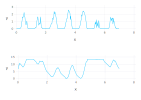

In [164]:
fig1a = plot(x=td, y=P_sun, Geom.line)
fig1b = plot(x=td, y=E[1:end-1], Geom.line)
fig1 = vstack(fig1a, fig1b)

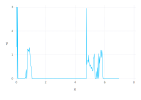

In [165]:
plot(x=td, y=P_grid, Geom.line)